# Axolotl Build dummy search method example [Binary Classification].

In this example, we are showcasing different components of the system.
- Loading syntethic data for a binary classification task.
- Easy use of the backend.
- Creation of custom rank function as well as a simple search method.
- Use of simple interface for search.
- Exploring searched pipelines.

## Import multiple utils we will be using

In [1]:
import uuid
import random
import pandas as pd
from pprint import pprint
from sklearn.datasets import make_classification

from d3m import container
from d3m.metadata.pipeline import Pipeline

from axolotl.utils import data_problem
from axolotl.backend.ray import RayRunner
from axolotl.algorithms.base import PipelineSearchBase
from axolotl.utils import pipeline as pipeline_utils, schemas as schemas_utils

### Generate synthetic data and import it to the system

In [2]:
x, y = make_classification(n_samples=100, n_features=20)
dataset, problem_description = data_problem.generate_dataset_problem(x, y, 'binary_classification')

### Make an instance of the runner that is in charge of evaluating and running pipelines.

In [3]:
backend = RayRunner(random_seed=42, volumes_dir=None, n_workers=4)

2020-07-11 19:07:52,353	INFO resource_spec.py:212 -- Starting Ray with 3.56 GiB memory available for workers and up to 1.79 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-11 19:07:52,793	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


### Create a random rank function.

In [4]:
def random_rank(pipeline_result):
    if pipeline_result.status == 'COMPLETED':
        pipeline_result.rank = random.uniform(0, 1)
    return pipeline_result

### Create a predefined Search algorithm that is loading some predefined pipelines previosuly stored.

In [5]:
class PredefinedSearch(PipelineSearchBase):
    def __init__(self, problem_description, backend, *, primitives_blocklist=None, ranking_function=None):
        super().__init__(problem_description=problem_description, backend=backend,
                         primitives_blocklist=primitives_blocklist, ranking_function=ranking_function)
        if self.ranking_function is None:
            self.ranking_function = random_rank
        self.task_description = schemas_utils.get_task_description(self.problem_description['problem']['task_keywords'])

        self.available_pipelines = self._return_pipelines(
            self.task_description['task_type'], self.task_description['task_subtype'], self.task_description['data_types'])

        # Selection of a data preparation pipeline, we provide some predefine options such as train_test_split, k_fold, etc
        # as well as the user can provide their own.
        self.data_preparation_pipeline = schemas_utils.get_splitting_pipeline("K_FOLD")
        
        # Get the metrics to evaluate the pipelines based on the problem description.
        self.metrics = self.problem_description['problem']['performance_metrics']

        # Pipeline to be use for scoring, we recommend using the one provided.
        self.scoring_pipeline = schemas_utils.get_scoring_pipeline()
        
        # Get the parameters for the datapreparation pipeline, such as number of folds, and so on.
        self.data_preparation_params = schemas_utils.DATA_PREPARATION_PARAMS['k_fold_tabular']

        self.offset = 10
        self.current_pipeline_index = 0

    def _search(self, time_left):
        # Read all the pipelines to be evaluated
        pipelines_to_eval = self.available_pipelines[self.current_pipeline_index: self.current_pipeline_index+self.offset]
        self.current_pipeline_index += self.offset
        
        # Evaluate the pipelines.
        pipeline_results = self.backend.evaluate_pipelines(
            problem_description=self.problem_description, pipelines=pipelines_to_eval, input_data=self.input_data,
            metrics=self.metrics, data_preparation_pipeline=self.data_preparation_pipeline,
            scoring_pipeline=self.scoring_pipeline, data_preparation_params=self.data_preparation_params)

        return [self.ranking_function(pipeline_result) for pipeline_result in pipeline_results]

    def _return_pipelines(self, task_type, task_subtype, data_type):
        pipeline_candidates = []
        for pipeline_dict in schemas_utils.get_pipelines_db()['CLASSIFICATION']:
            pipeline = pipeline_utils.load_pipeline(pipeline_dict)
            pipeline.id = str(uuid.uuid4())
            pipeline.created = Pipeline().created
            pipeline_candidates.append(pipeline)

        return pipeline_candidates


### Create an instance of the search and fit with the input_data.

In [6]:
# The method fit search for the best pipeline based on the time butget and fit the best pipeline based on the rank with the input_data.
search = PredefinedSearch(problem_description=problem_description, backend=backend)
fitted_pipeline, pipeline_result = search.search_fit(input_data=[dataset], time_limit=30)

### Print information about scores of the succeded pipelines.

In [7]:
for pipeline_result in search.history:
    print('-' * 52)
    print('Pipeline id:', pipeline_result.pipeline.id)
    print('Rank:', pipeline_result.rank)
    print(pipeline_result.scores)

----------------------------------------------------
Pipeline id: dbca8f6a-ad11-4e32-9bc1-b49c554ff224
Rank: 0.11134933476057562
     metric     value  normalized  randomSeed  fold
0  ACCURACY  0.588235    0.588235          42     0
1  ACCURACY  0.878788    0.878788          42     1
2  ACCURACY  0.818182    0.818182          42     2


### Display succeded pipelines

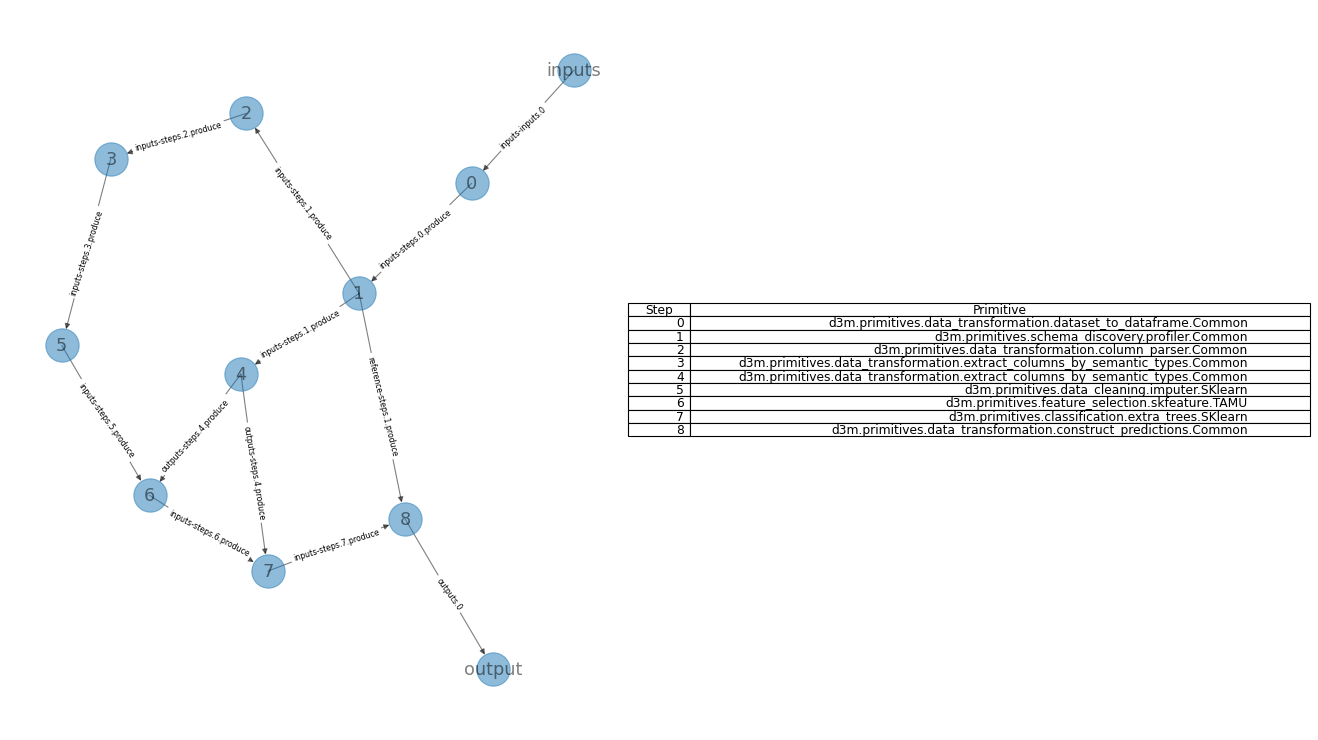

In [8]:
for result in search.history:
    pipeline_utils.plot_pipeline(result.pipeline)